In [1]:
import torch
import sys
sys.path.append("..")

from model import Model, restore
from dataset import ModisDataset, download_url
import matplotlib.pyplot as plt
import numpy as np
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

tumblack = "#000000"
tumblue = "#0065bd"
tumorange = "#e37222"
tumbluelight = "#64a0c8"
tumgray = "#999999"
tumlightgray = "#dad7cb"


In [ ]:
%%bash
if [ ! -d "/tmp/models" ]; then
  wget -nc -P /tmp https://syncandshare.lrz.de/dl/fi5Y1ZUyaY38NLXSzbbynDmA/models.tar.gz
  tar -xzf /tmp/models.tar.gz -C /tmp --keep-new-files
fi

In [2]:
device = torch.device("cuda")

model_dir = "/tmp/models"
name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}.pth"

input_size=1
hidden_size=64
num_layers = 1
region="germany"
epoch=3

model = Model(input_size=1,
              hidden_size=hidden_size,
              num_layers=num_layers,
              output_size=1,
              device=device)
#download_url("https://syncandshare.lrz.de/dl/fiDSPeiaaQtP18a7maBN8okj/model_epoch_8.pth", "/tmp/model.pth")

model_name = name_pattern.format(region=region, num_layers=num_layers, hidden_size=hidden_size, epoch=epoch)
pth = os.path.join(model_dir, model_name)

print(f"loading model from {pth}")

#model.load_state_dict(torch.load(pth)["model"])
restore(pth, model)
model.train()
dataset = ModisDataset(region="germany",fold="validate", znormalize=True)

def variance(y_hat, var_hat):
    """eq 9 in Kendall & Gal"""
    T = y_hat.shape[0]
    sum_squares = (1/T) * (y_hat**2).sum(0)
    squared_sum = ((1/T) * y_hat.sum(0))**2
    epi_var = sum_squares - squared_sum
    ale_var = (1/T) * (var_hat**2).sum(0)
    return epi_var + ale_var, epi_var, ale_var

def epistemic_variance(y_hat):
    """eq 4 in Kendall & Gal"""
    return (y_hat**2).mean(0) - y_hat.mean(0)**2


def predict(x, date, N_seen_points = 250, N_predictions = 50, ylim=None):

    future = x.shape[0] - N_seen_points

    fig, axs = plt.subplots(3,1,figsize=(14, 10))
    axs = np.array(axs).reshape(-1)

    axs[0].set_title("epistemic uncertainty")
    axs[1].set_title("aleatoric uncertainty")
    axs[2].set_title("combined uncertainty")

    y_hat = list()
    var_hat = list()
    for idx in range(N_predictions):
        model.train()
        x_data = torch.Tensor(x)[None, :N_seen_points].to(device)
        with torch.no_grad():
            y_pred, log_variance = model(x_data, future=future)

        y_hat.append(y_pred[0,:,0].cpu().detach().numpy())
        var_hat.append(log_variance[0,:,0].exp().cpu().detach().numpy())

    var_hat = np.vstack(var_hat)
    y_hat = np.vstack(y_hat)


    var, epi_var, ale_var = variance(y_hat, var_hat)
    #epi_var = epistemic_variance(y_hat)
    #var = ale_var + epi_var

    #sum_squares_var = (1/T) * (var_hat**2).sum(0)

    mean = y_hat.mean(0)[:-1]

    n_sigma=1
    axs[0].fill_between(date[1:], mean+n_sigma*np.sqrt(epi_var[:-1]), mean-n_sigma*np.sqrt(epi_var[:-1]), alpha=.5, label=f"epistemic {n_sigma}"+r"$\sigma$")
    axs[1].fill_between(date[1:], mean+n_sigma*np.sqrt(ale_var[:-1]), mean-n_sigma*np.sqrt(ale_var[:-1]), alpha=.5, label=f"aleatoric {n_sigma}"+r"$\sigma$")
    axs[2].fill_between(date[1:], mean+n_sigma*np.sqrt(var)[:-1], mean-n_sigma*np.sqrt(var)[:-1], alpha=.5, label=r"combined $\sigma$")

    for ax in axs:
        ax.plot(date[:N_seen_points], x[:N_seen_points,0], c="#000000", alpha=1, label="seen input sequence")
        ax.plot(date[N_seen_points:], x[N_seen_points:,0], c="#000000", alpha=.1, label="unseen future")
        ax.axvline(x=date[N_seen_points], ymin=0, ymax=1)
        if ylim is not None:
            ax.set_ylim(ylim)
        #ax.plot(date[1:], mean,'r')


    for y_pred in y_hat:
        label = "prediction" if idx == 0 else None
        ax.plot(date[:N_seen_points + future], y_pred, c=tumorange, label=label, alpha=(1 / N_predictions) ** 0.7)

    [ax.legend( ncol=3) for ax in axs]
    
    return fig,axs

loading model from /tmp/models/LSTM_germany_l=1_h=64_e=3.pth
restoring model from /tmp/models/LSTM_germany_l=1_h=64_e=3.pth
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz


In [3]:
from visualizations import make_and_plot_predictions

(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48403e7e48>,
       dtype=object))

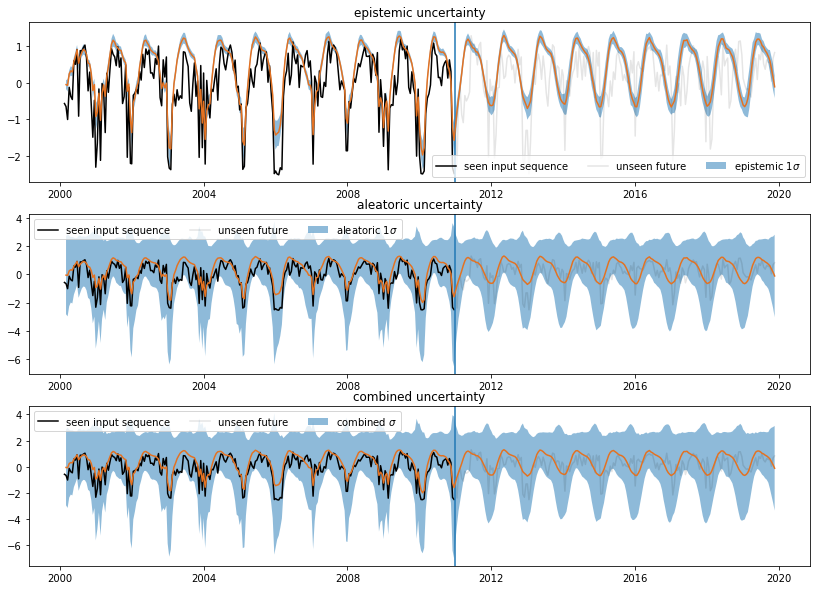

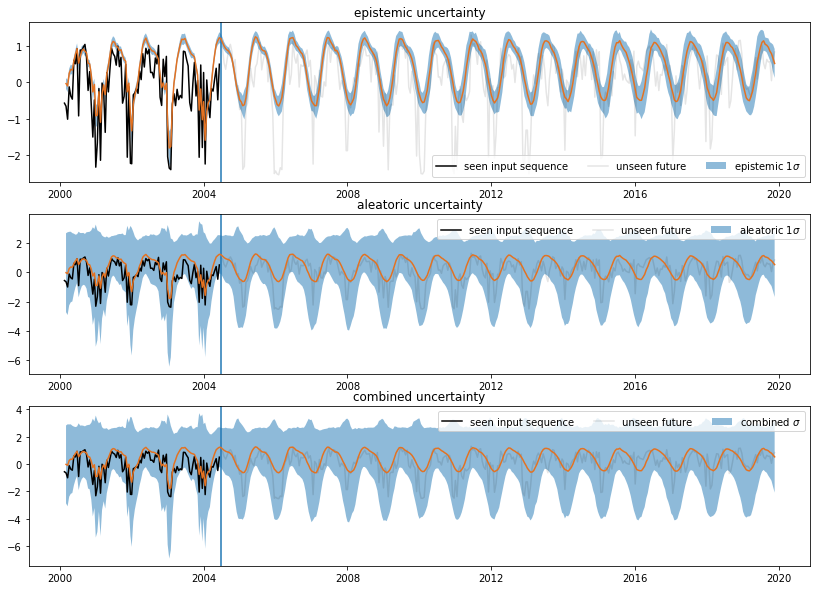

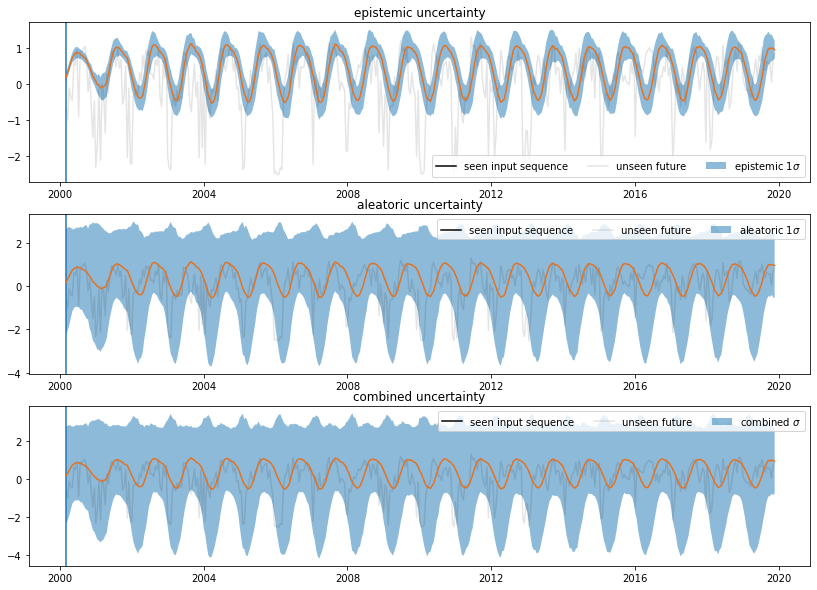

In [4]:
idx = 30

x = dataset.data[idx].astype(float)
date = dataset.date[idx].astype(np.datetime64)

make_and_plot_predictions(model, x,date,N_seen_points = 250, N_predictions = 50, device=device)
make_and_plot_predictions(model, x,date,N_seen_points = 100, N_predictions = 50, device=device)
make_and_plot_predictions(model, x,date,N_seen_points = 1, N_predictions = 50, device=device)

#ax.set_ylim(0,1)


## A Bad Example

This may be a out-of-distribution example. I suppose there are only few samples like this one in the dataset. The offset is really ugly. Still here the epistemic uncertainty should be mich larger that it really is

(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f98734af160>,
       dtype=object))

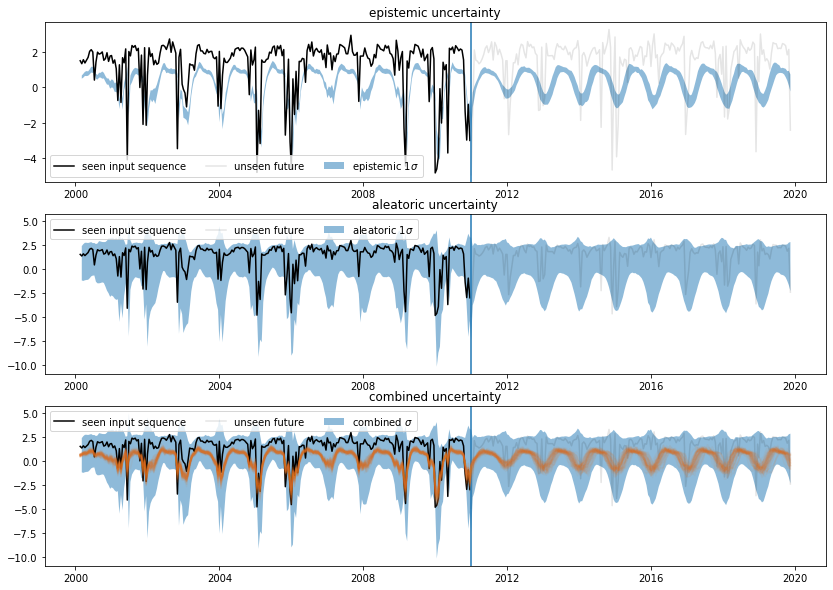

In [22]:
idx = 1
x = dataset.data[idx].astype(float)
date = dataset.date[idx].astype(np.datetime64)
predict(x,date,N_seen_points = 250, N_predictions = 50)

In [5]:
import os
import tqdm
from tqdm import tqdm_notebook

#os.mkdir("/tmp/anim/")

In [ ]:
directory="/tmp/anim"
if not os.path.exists(directory):
    os.makedirs(directory)

for i in tqdm_notebook(range(1,454),total=454):
    fig,_ = predict(x,date,N_seen_points = i, N_predictions = 10, ylim=(-6,3))
    fig.savefig(directory+f"/{i:03d}.png")
    fig.clf()
    
!ffmpeg -r 30 -f image2 -s 1920x1080 -i directory+"/%03d.png" -vcodec libx264 -crf 25  -pix_fmt yuv420p /tmp/anim.mp4

/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [46]:
import io
import base64
from IPython.display import HTML

video = io.open('/tmp/anim.mp4', 'r+b').read()
encoded = base64.b64encode(video)

HTML(data='''<video alt="test" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))

In [43]:
!ls "/tmp/anim.mp4"

/tmp/anim.mp4
